# CDR: High Level Turbine Design

> Author: Elias Aoubala

> Date: 21/04/2025

In [255]:
from turborocket.meanline.meanline_relations import TurbineStageDesign
from turborocket.fluids.fluids import IdealGas
from turborocket.profiling.Supersonic.supersonic_profile import SymmetricFiniteEdge
from turborocket.profiling.Supersonic.circular import inv_M_star, M_star
import numpy as np
import pandas as pd
import handcalcs.render
import matplotlib.pyplot as plt

## 1 - Background

This document encapsulates the work towards the development of the second iteration of the turbine stage of the "Mermaidman and Barnacle Boy" turbopump being developed by the Open Turbopumps amature group.

This document highlights the high-level fluidic design and analyiss conducted for the turbine.

## 2 - High-Level Specifications

Based on the previous studies performed, the following key inputs have been used on the high-level turbine design:

| Parameter        | Value      | Justification                                                                                                       |
| ---------------- | ---------- | ------------------------------------------------------------------------------------------------------------------- |
| Shaft Speed      | 24,000 RPM | Based on the preliminary rotor dynamic analysis, advancing the shaft speed to 30,000 RPM was identified as feasible |
| Pump Power      | 11 kW       | This is the most up-to date pump power requirement                                                                  |

The following inputs from the gas-generator study have additionally been provided:

| Parameter                      | Value       | Justification                                                |
| ------------------------------ | ----------- | ------------------------------------------------------------ |
| Nominal Mixture Ratio          | 1           | Based on Sensitivity Study Conducted on Gas Generator Design |
| Inlet Pressure ($P_o$)         | 20e5        | Based on Sensitivity Study Conducted on Gas Generator Design |
| Inlet Temperature ($T_o$)      | 858 K       | Based on Sensitivity Study Conducted on Gas Generator Design |
| Specific Heat Capacity ($C_p$) | 8575 J/kg K | Based on Sensitivity Study Conducted on Gas Generator Design |
| Specific Heat Ratio ($\gamma$) | 1.164       | Based on Sensitivity Study Conducted on Gas Generator Design |
| Specific Gas Constant (R)      | 518.949 | Based on Sensitivity Study Conducted on Gas Generator Design |



For the sake of consistency, we will parameterise these inputs in an array as was previously shown.

In [256]:
dic_gg = {
    "P_cc": 2500000.0,
    "MR": np.float64(1.0),
    "T_o": 868.1694130102591,
    "Cp": 2242.4288383607086,
    "gamma": 1.290332008352664,
    "R": 504.5591863293963,
    "ox_stiffness": 1.0,
    "fu_stiffness": 1.0,
    "m_dot_t": 0.078053,
    "m_dot_o": 0.0390265,
    "m_dot_f": 0.0390265,
}


dic_gg_geom = {
    "CdA_ox": np.float64(6.215063856482116e-07),
    "CdA_fu": np.float64(6.22534363430164e-07),
    "A_fu": np.float64(1.5563359085754099e-06),
    "A_ox": np.float64(1.2430127712964233e-06),
    "Acc": 3.10497882e-05,
}


dic_rotor = {
    "N_shaft": 24e3,
    "u_cis": 0.1,
    "Rt": 13,
    "phi_n": 0.85,
    "alpha": 70,
    "delta_r": 2e-3,
    "N_nozzle": 6,
    "N_rotor": 30,
    "power": 10 + 0.4*4
}

As we only have the power requirements for the pump, we must now derive the power requirements for the shaft, when considering the losses via the bearings and shaft seal.

## 3 - Power Requirements Considering Mechanical Losses

In the shaft design, we have two bearings being used, along with a mechanical seal.

Inorder to determine the losses, we will use `SKF` to estimate the resitive torques expected for both of these bearings.

To do so, we need a rough estimation of what the forces carried by the bearings will be.

A calculation was conducted in the `bearings.ipynb` document for the expected mechanical losses for the system, which was evaluated at approximately 1.6 kW.

This brings the total power requirement for the turbine to 5.6 kW.

We can take an additional 30% Margin against this power requirement, to derive a required turbine power of **7.28 kW**

## 4 - Initialising our Runnning Parameters

As this problem is an optimisation problem, we will manually initialise these until we reach a good operating point.

In [257]:
b = 15e-3
t = 5e-3

## 5 - Turbine Fluidic Design with Geometry Specification

Based on these inputs, we can derive the required turbine power accordingly - using our refined loss model.

The main parameter we will iterate on the GG mass flow rate untill we reach our target power. We will do an adjoint-esque iterative study until the power requirement is reached.

We will instantiate an inital error of 0

In [258]:
error = 0

### 5.1 - Optimisation Loop for System Power

We will use a relaxation factor of **0.4** for the adjoint solver based on the relative error from the target power.

In [372]:
relax = 0.4

dm = dic_gg["m_dot_t"]*error*relax

dic_gg["m_dot_t"] -= dm

In [373]:
print(f"Blade Chord Length: {b*1e3}")
print(f"Blade Spacing: {t*1e3}")

Blade Chord Length: 19.886408603092196
Blade Spacing: 10.888695442541731


In [374]:
fluid = IdealGas(
    p=dic_gg["P_cc"],
    t=dic_gg["T_o"],
    gamma=dic_gg["gamma"],
    cp=dic_gg["Cp"],
    R=504,
)

stage = TurbineStageDesign(gas=fluid, m_dot=dic_gg["m_dot_t"], omega=dic_rotor["N_shaft"], alpha=(90 - dic_rotor["alpha"]))

stage.set_operating_point(u_cis=dic_rotor["u_cis"], Rt=dic_rotor["Rt"], b=b, t=t, delta_r=dic_rotor["delta_r"], N=dic_rotor["N_nozzle"])

result = stage.solve_performance(phi_n=dic_rotor["phi_n"])

Current Error: 15.688560704983207 %
Current Error: 1.1352838217160341 %
Current Error: 0.09306638144681581 %
Current Error: 0.007556043462195178 %


We can get out power produced and calculate our error to repeat once again.

In [375]:
P = result["performance"]["Power"] * 1e-3

error = (P - dic_rotor["power"]) / dic_rotor["power"]

print(f"Relative Error: {error*1e2:.2f} %")

Relative Error: -0.00 %


**Final Gas Generator Mass Flow Rate**

In [376]:
%%render param

m_dot_t = dic_gg["m_dot_t"]*1e3 # g/s

<IPython.core.display.Latex object>

### 5.2 - Getting System Performance

We can now get an idea of the specific power of the turbine and the associated performance Metrics

In [377]:
performance_dic = result["performance"]
performance_dic = {k: [v] for k, v in performance_dic.items()}
performance_df = pd.DataFrame(performance_dic)

pressure_dic = result["pressure"]
pressure_dic = {k: [v] for k, v in pressure_dic.items()}
pressure_df = pd.DataFrame(pressure_dic)

velocity_dic = result["velocity"]
velocity_dic = {k: [v] for k, v in velocity_dic.items()}
velocity_df = pd.DataFrame(velocity_dic)

temperature_dic = result["temperature"]
temperature_dic = {k: [v] for k, v in temperature_dic.items()}
temperature_df = pd.DataFrame(temperature_dic)

geometry_dic = result["geometry"]
geometry_dic = {k: [v] for k, v in geometry_dic.items()}
geometry_df = pd.DataFrame(geometry_dic)

mach_dic = result["mach"]
mach_dic = {k: [v] for k, v in mach_dic.items()}
mach_df = pd.DataFrame(mach_dic)

angles_dic = result["angles"]
angles_dic = {k: [v] for k, v in angles_dic.items()}
angles_df = pd.DataFrame(angles_dic)

**Performance**

In [378]:
performance_df["Power (kW)"] = performance_df["Power"].multiply(1e-3)
performance_df["Torque (Nm)"] = performance_df["Power"] / (25000 * 2 *np.pi/60)

performance_df

,dh,eps,phi_r,phi_l,m_leakage,eta_l,phi,eta_h,zeta_eps,eta_o,Power,Power (kW),Torque (Nm)
0,853658.556771,0.210303,0.696805,0.287086,0.023858,0.712914,0.85,0.234655,0.003777,0.163512,11599.947675,11.599948,4.430854


As can be seen, we are getting an efficiency on the order of **45%** with a specific power of 987 kW/kg/s

This works out to a GG size of the following:

**Pressures**

In [379]:
pressure_df * 1e-5

,p_0,p_1,p_1o,p_1o_r,p_2o_r,p_2o
0,25.0,1.923077,10.439256,7.716615,3.569426,2.990127


**Temperatures**

In [380]:
temperature_df

,t_0,t_1,t_1o_r,t_2,t_2o
0,868.169413,592.819489,811.099475,705.116335,778.74054


**Geometry**

In [381]:
geometry_df["Nozzle Throat (mm)"] = [(dic_gg_geom["Acc"] / (dic_rotor["N_nozzle"]* np.pi))**(1/2) * 2 * 1e3]
geometry_df["Nozzle Exit (mm)"] = geometry_df["s_c"]*1e3
geometry_df["eps"] = geometry_df["A_1"] / geometry_df["A_0"]

throat_error = (geometry_df["A_0"][0] - dic_gg_geom["Acc"] )/ dic_gg_geom["Acc"]

print(f"Comparison of Throat Calculated using CEA: {throat_error*100:.1f} %")

geometry_df

Comparison of Throat Calculated using CEA: 6.4 %


,D_m,A_1,A_0,s_c,s_b,D_hub,D_tip,AR,Nozzle Throat (mm),Nozzle Exit (mm),eps
0,0.103979,0.000116,0.000033,0.004967,0.007467,0.096513,0.111446,0.375474,2.566899,4.966839,3.518494


**Mach**

In [382]:
mach_df

,m_star_c1,m_star_w1,m_star_w2,m_star_c2
0,1.581765,1.457041,1.015274,0.817918


**Angles**

In [383]:
90 -angles_df

,beta_1,beta_2,alpha_2
0,67.409767,89.54866,49.602212


**Velocities**

In [384]:
velocity_df

,u,c_1s,c_1,w_1,a_star_2,w_2,c_2,a_star_3
0,130.664345,1306.643453,1110.646935,988.872957,678.685921,689.051898,574.30666,665.009994


## 6 - Profile Design

Here we can generate our turbine blade profile, by using the "profiling" submodule of the `turborocket` python package.

A reasonable blade leading edge has been assumed for this analysis.

A reverse computation is performed to evaluate for the inlet mach number, based on the inlet M_star number.

We will assume a given number of blades at this stage

In [385]:
M_i = inv_M_star(M_star=mach_df["m_star_w1"][0], gamma=fluid.get_gamma())

M_star_w = mach_df["m_star_w1"][0]

super = SymmetricFiniteEdge(
    beta_ei = (90 - angles_df["beta_1"][0]),
    beta_i = (90 - angles_df["beta_1"][0]), 
    M_i=M_i,  # Relative Mach Numbers Nominally
    M_u=1.8,
    M_l=1.1,
    m_dot=1,
    h=10e-3,
    t_g_rat=0.12,
    g_expand=0.2,
    le_angle=20,
    fluid = fluid,
)

super.prantl_meyer()

super.generate_turbine_profile()
super.get_performance()

Initial Solidity: 2.4545946117781208
Final Solidity: 1.8263352766206256


{'M_u_max': np.float64(1.8918742453215922),
 'M_u_margin': np.float64(0.05104124740088453),
 'M_l_min': np.float64(1.0069304855450651),
 'M_l_margin': np.float64(0.08460864950448631),
 'M_e_max': np.float64(1.580602302256787),
 'M_e_margin': np.float64(0.1410810288639159)}

We can now get the geometry sized

In [386]:
profile_geometry = super.size_geometry(D_m=geometry_df["D_m"][0], N=dic_rotor["N_rotor"])
b = profile_geometry["b"]
t = profile_geometry["t"]

print(f"Blade Spacing: {t*1e3:.2f} mm")
print(f"Blade Chord Length: {b*1e3:.2f} mm")

depth = (geometry_df["D_tip"][0]/2 - geometry_df["D_hub"][0]/2)

print(b)
print(geometry_df["D_hub"][0])
print(geometry_df["D_tip"][0])

print(f"CNC Mill L/D Ratio: {depth/t:.2f}")

Blade Spacing: 10.89 mm
Blade Chord Length: 19.89 mm
0.019886408603092195
0.09651254297293305
0.11144622144739208
CNC Mill L/D Ratio: 0.69


In [387]:
np.append(np.linspace(100,100,10), np.linspace(100,200,10)[1:])


array([100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 111.11111111, 122.22222222,
       133.33333333, 144.44444444, 155.55555556, 166.66666667,
       177.77777778, 188.88888889, 200.        ])

We can plot the passage geometry

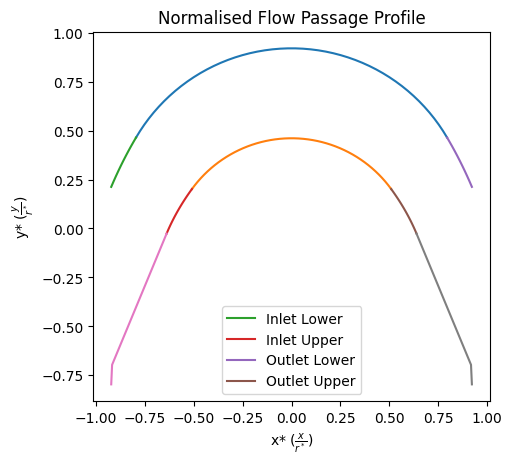

In [388]:
super.plot_passage()


We can get the blade passage spacing and figure out our L/D of the geometry

Finally we can plot the scaled geometry

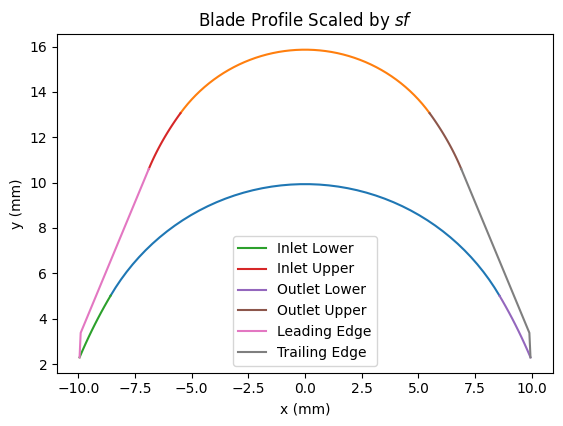

In [389]:
super.plot_scaled()

We can then generate our blade file

0     -6.783821
1     -6.772803
2     -6.761784
3     -6.750766
4     -6.739748
         ...   
707   -5.330404
708   -5.608568
709   -5.892993
710   -6.183627
711   -6.783821
Name: y, Length: 712, dtype: float64


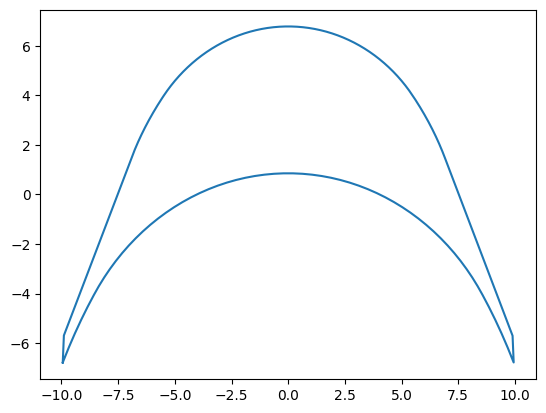

In [390]:
k = super.generate_xy()
k.to_csv("blade.txt", sep="\t", index=False)

plt.plot(k["x"], k["y"])

print(k["y"])

### 6.1 - Manufacturing Assement

As we intent to CNC the Blisk, we must confirm that the actual passage geometry is manufacturable or not.

To do this we need to get an idea of what the blade passage is for us to evaluate for the L/D of the passage.

We will make this assesment based on the thinnest point of the passage, which in this case would be the inlet of the turbine.

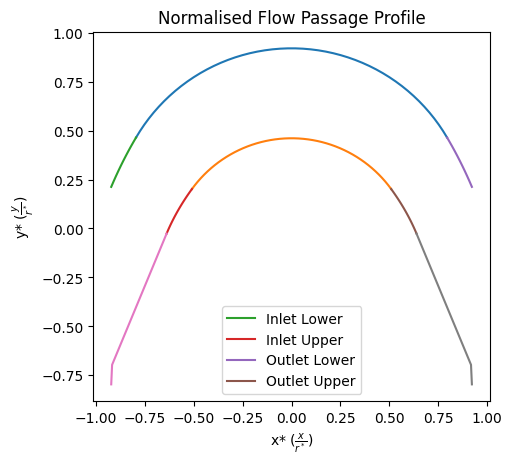

In [391]:
super.plot_passage()


In [392]:
super.generate_surface_maps()
s = super.get_passage_spacing()

s_b = geometry_df["s_b"][0]

L_D = s_b/s

print(f"Blade Spacing: {s*1e3:.2f} mm")
print(f"Blade Height: {s_b*1e3:.2f}")
print(f"Passage L/D : {L_D}")

Blade Spacing: 4.96 mm
Blade Height: 7.47
Passage L/D : 1.505925531651689


We can set a conservative budget on the L/D in that it should not be more than 1.5 to be manufacturable. Anything in excess mayv be challenging from suppliers.

We augment this by iterating through varying blade counts on the rotor until our L/D is satisfactory

## 7 - Profile and Operating Point

The following key Parameters have been derived from this study:

| Parameter                | Value        |
| ------------------------ | ------------ |
| Gas Generator Mass Flow  | 28 g/s       |
| Shaft Speed              | 25,000 rpm   |
| Nozzle outlet Area       | 0.000044 m^2 |
| Nozzle Throat (GG Param) | 0.000011 m^2             |
|                          |              |

The following Power Requirement is present

In [280]:
%%render params

acceptable = (dic_rotor["power"] < performance_df["Power (kW)"][0])

Power = performance_df["Power (kW)"][0]

<IPython.core.display.Latex object>

## 8 - Rotor Geometry Design

Based on the profile generated using the `turborocket` python package, the geometry was imported into a CAD package via the x-y-z output. A "Blisk" based geometry was selected for the rotor.

In the interest of reducing the weight and second moment of inertia of the turbine assembly, the a webbing based strategy was selected for the blisk geometry - where the main hub would be contracted inwards and thus reduce the mass of the system.

Two fillets between these contractions are present to reduce stress concentrations.

Image of the overall blisk:

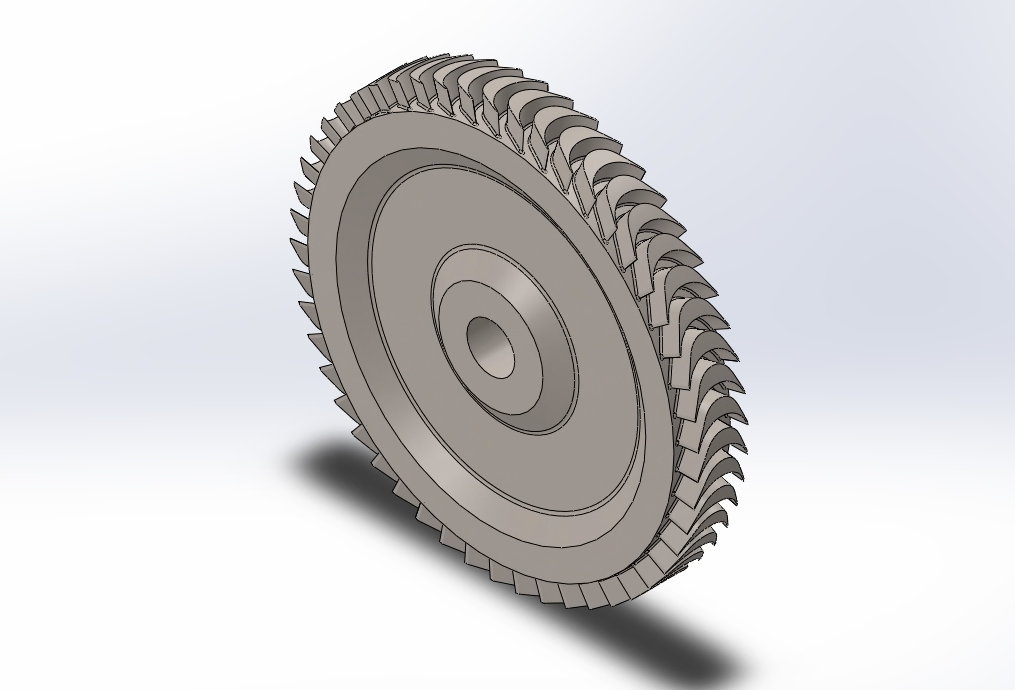

Crossectional Image of the Blisk shape:

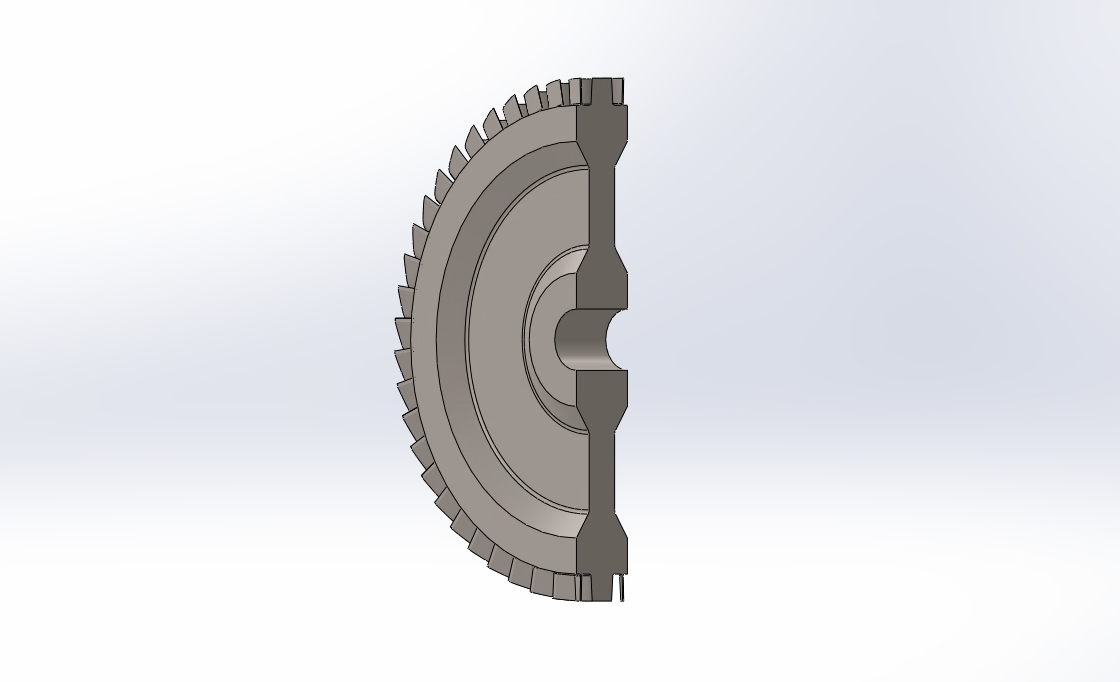

The following sections contain the authors stress analysis and optimisation study for the blisk geometry.

### 8.1 - Blisk Stress Analysis and Optimisation

#### 8.1.1 - Initial Stress Analysis

The initial stress analysis conducted was focused on the rotational stresses induced on the blisk given the high rotational rate that the turbine is operating at.

A cross section consisting of 5 blades was created as shown below:

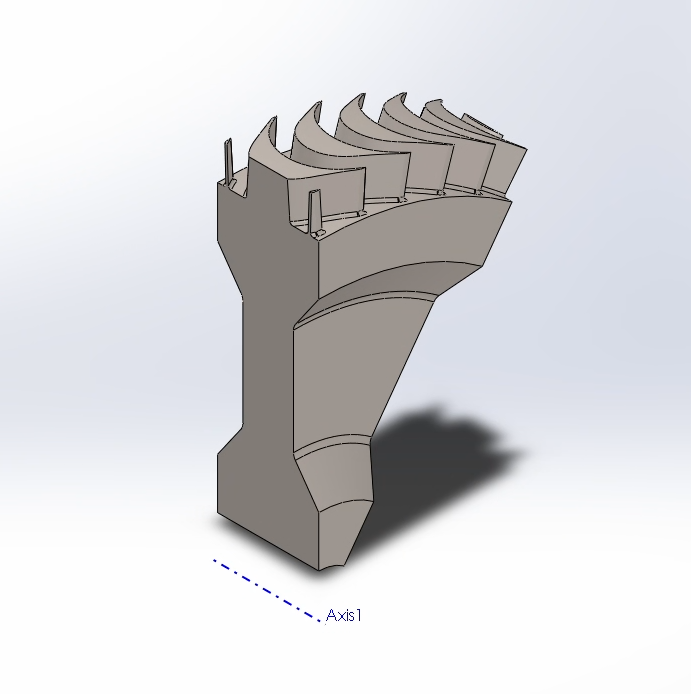


Roller constraints were applied on each side, along with a cyclic symmetry condition.

A rotational rate of 2513 rad/s was evaluated (24k RPM).

The following result was obtained.

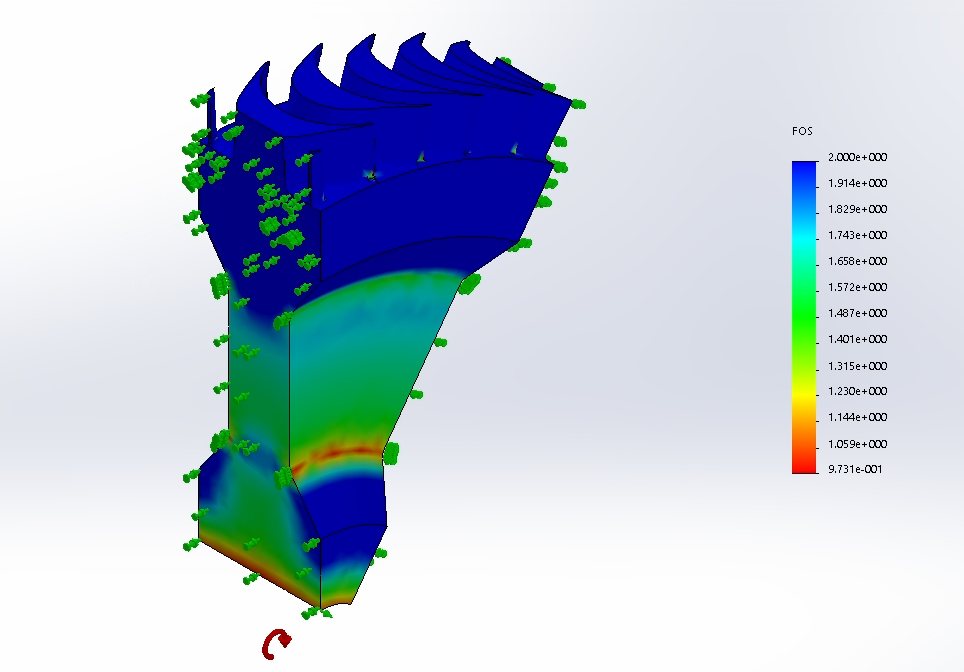

Extremely high stresses had been identified, with particular stress concentrations being at the fillet of the contraction, along with the web itself.

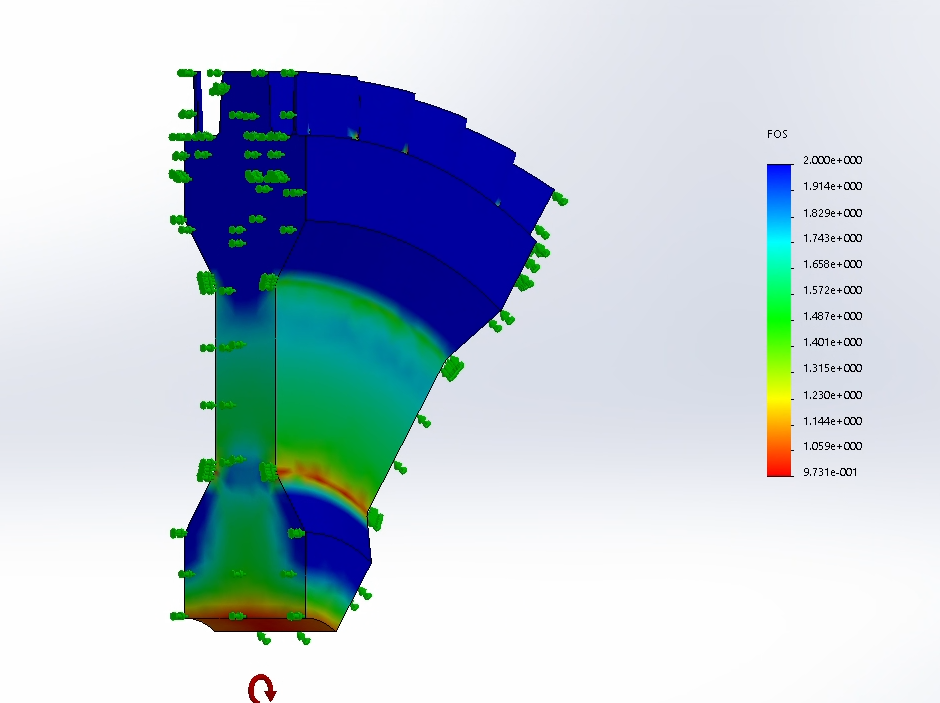

A minimum factor of safety of 0.97 had been identified which was unacceptable, and thus an iterative study was conducted to increase this factor of safety accordingly.

#### 8.1.2 - Blade Geometry Optimisation

The blade upper section was reduced from 20 mm to 10mm, along with the fillet radii increased from 2 mm to 4 mm.

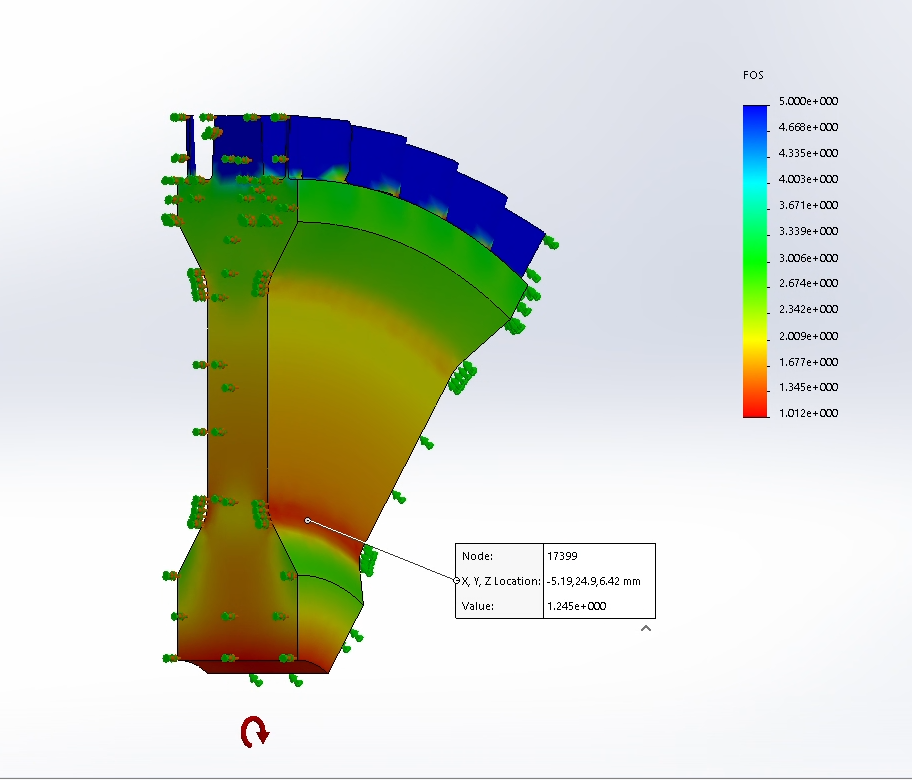

The stress concentration was still fairly signficant, hence it was action that the web thickness should be increased and the radii further increased.

Increasing the web thickness from 10 mm to 13 mm resulted in the following:

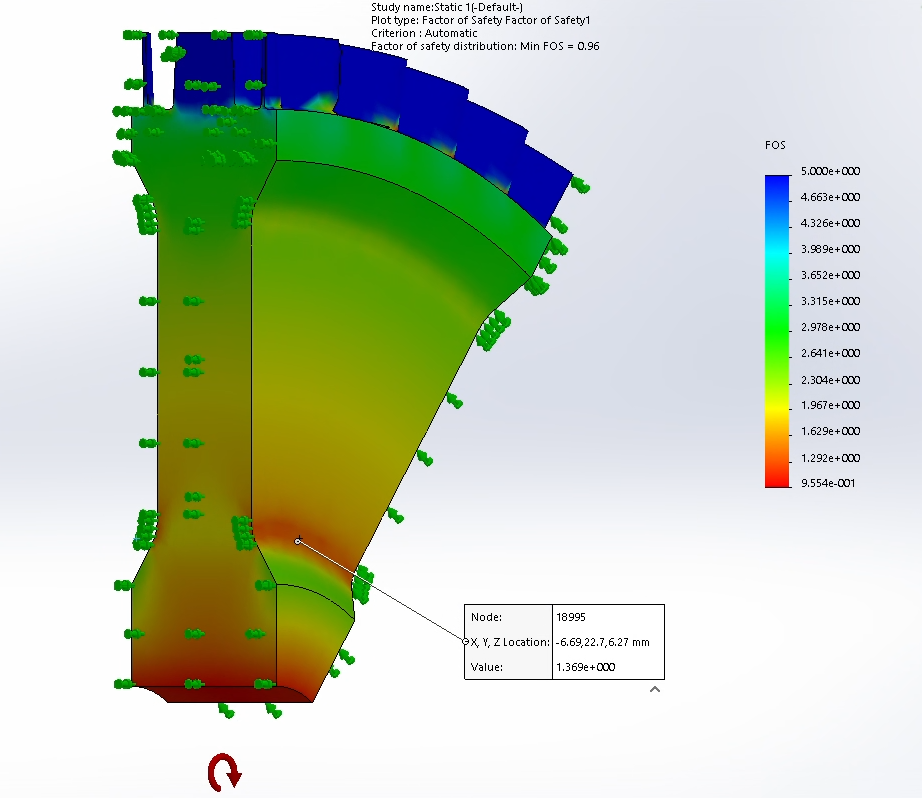

This had further reduced the stress concentration athte lower section.

The next point of investigation was to see if increasing the lower section thickness would reduce the stress formations at the lower setion. An increase from 20 mm thickness to 25 mm thickness was performed to see if the stresses in the lower section would be accordingly reduced.

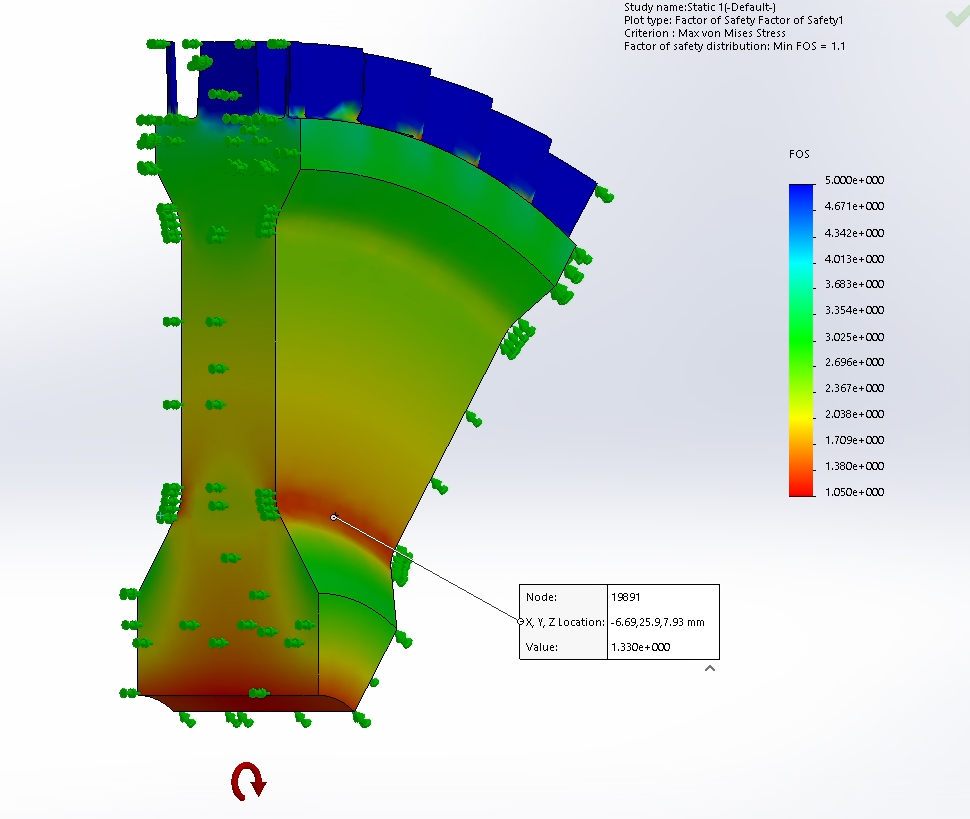

The stress concentration at the fillet had increased, but the overall stress had decreased indicating an improvement.

A potential measure to resolve this is to reduce the web thickness back to the original - increase that fillet signficantly larger, and have the lower section thick as we originally had.

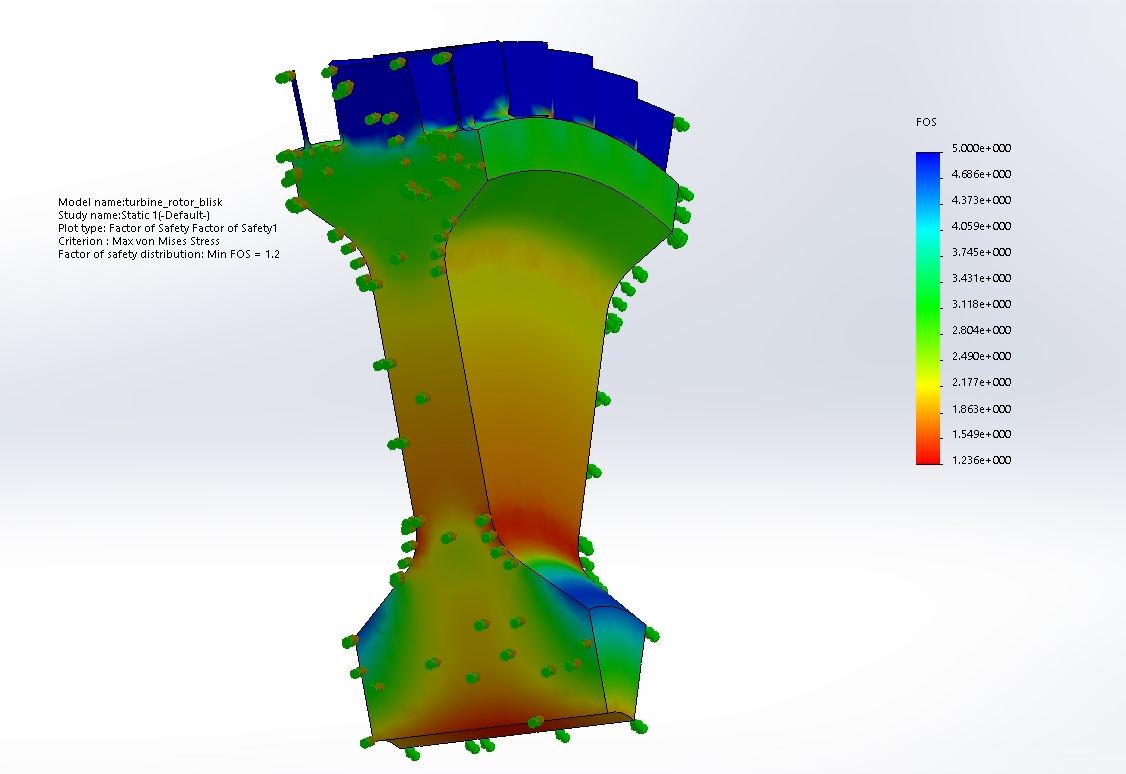

Lets try and reduce the based depth a little as our factors are quite large and see where that puts us

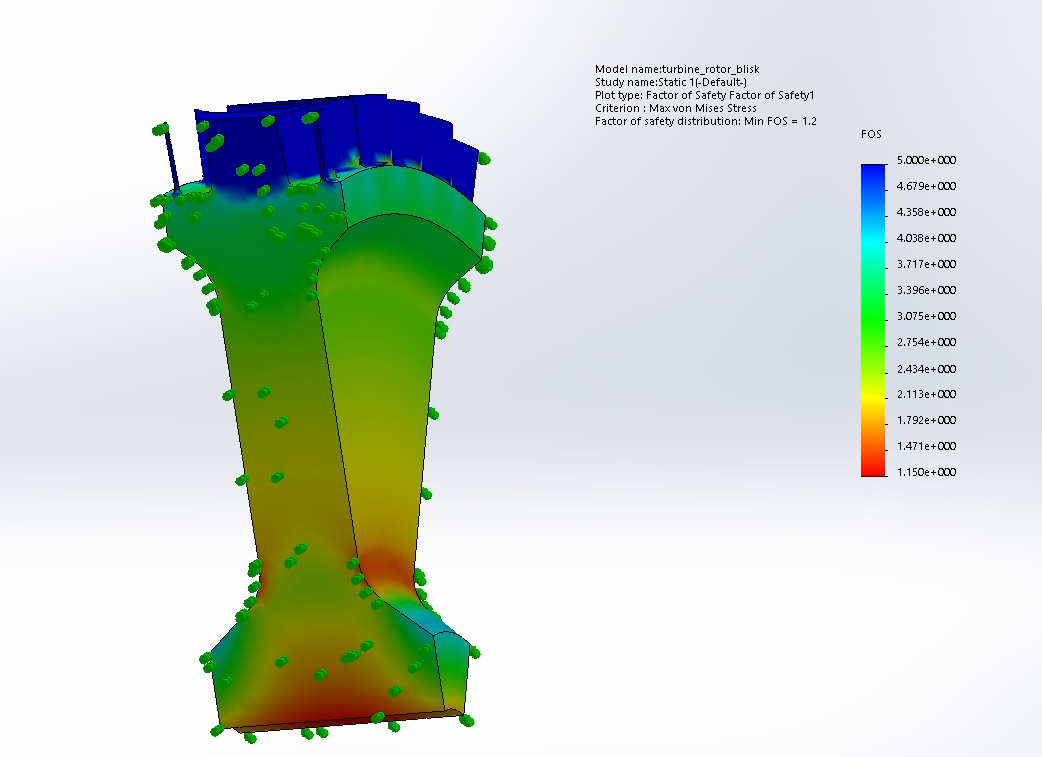

Lets try and increase out shaft diameter to maybe reduce the stress loading.

### 8.2 - Reduction in meanline length of Turbine

The strategy here is that we decrease the velocity ratio of the turbine, having an impact on the efficiency - but by consequence we can decrease the meanline diameter of the turbine down to 10 cm, which should reduce the stresses we see at the hub accordingly.

We can CAD this up accordingly.